[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/peteyeh/celltrack/HEAD)

In [1]:
%matplotlib inline

import cv2
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import six

from collections import Counter, OrderedDict
from radiomics import featureextractor
from scipy import stats
from SimpleITK import GetImageFromArray
from skimage.filters import threshold_multiotsu
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from displaytools import *
from improcessing import *

extractor = featureextractor.RadiomicsFeatureExtractor()
# Enable everything but shape (3D) and glcm.SumAverage
extractor.disableAllFeatures()
extractor.enableFeaturesByName(firstorder=[],
                               shape2D=[],
                               glcm=['Autocorrelation', 'JointAverage', 'ClusterProminence',
                                     'ClusterShade', 'ClusterTendency', 'Contrast',
                                     'Correlation', 'DifferenceAverage', 'DifferenceEntropy',
                                     'DifferenceVariance', 'JointEnergy', 'JointEntropy',
                                     'Imc1', 'Imc2', 'Idm', 'Idmn', 'Id', 'Idn',
                                     'InverseVariance', 'MaximumProbability', 'SumEntropy',
                                     'SumSquares'],
                               glszm=[],
                               glrlm=[],
                               ngtdm=[],
                               gldm=[])

scaler = StandardScaler()
pca = PCA(n_components='mle')
tsne = TSNE(learning_rate='auto', init='pca', random_state=0)

In [2]:
# Crops image to a region of interest
def crop_image(image):
    x, y, w, h = cv2.boundingRect(image)
    return image[y:y+h, x:x+w]

def display_classifications(image, centroids, labels):
    c = Counter(labels)
    for k in sorted(c):
        print("Class %s: %i (%.2f%%)" % (k, c[k], c[k]*100/sum(c.values())))
    plt.figure(dpi=240)
    plt.axis('off')
    plt.imshow(image, interpolation='nearest', cmap='gray')
    plt.scatter(*zip(*centroids), s=20, c=labels, marker='+', cmap=colormap, linewidths=1)
    plt.show()
    
def display_rois(image, masks, labels):
    for c in range(labels.min(), labels.max()+1):
        indices = np.where(labels==c)[0]
        print("Class %i, with %i ROIs:" % (c, len(indices)))
        masked = image*masks[indices]
        cropped = list(map(crop_image, masked))
        display_image_array(cropped, columns=10, dpi=150)

def display_tsne(df):
    transformed = tsne.fit_transform(df)
    plt.scatter(transformed[:,0], transformed[:,1], s=5, c=labels)
    plt.show()

def extract_features(image, mask_image, size_thresh=75):
    num_components, labelled, stats, centroids = \
            cv2.connectedComponentsWithStats(mask_image, connectivity=8)

    features = OrderedDict()
    masks = []

    for i in range(1, len(stats)):  # index 0 is the background component
        size = stats[i, -1]
        if size < size_thresh:
            continue
        mask = np.uint8(labelled == i)
        masks += [mask,]
        result = extractor.execute(GetImageFromArray(image),
                                   GetImageFromArray(mask))
        if len(features) == 0:
            features['x'] = [int(centroids[i][0])]
            features['y'] = [int(centroids[i][1])]
            for key, val in six.iteritems(result):
                if key.startswith("original_"):
                    features[key] = [val]
        else:
            features['x'] += [int(centroids[i][0])]
            features['y'] += [int(centroids[i][1])]
            for key, val in six.iteritems(result):
                if key.startswith("original_"):
                    features[key] += [val]

    return pd.DataFrame.from_dict(features).set_index(['x', 'y']), np.array(masks)

def get_mask_image(image, params, mode="thresh_otsu", verbose=False):
    if verbose:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
        hist1 = cv2.calcHist([image], [0], None, [256], [0,256])
        ax1.plot(hist1)
        ax1.set_title("Raw Image")
        ax1.set_xlim([0,256])
        ax1.set_ylim([0,hist1.max()])

    if params['denoise_pre']:
        image = apply_denoise(image, params['denoise_pre'])
    
    if params['clipLimit']:
        image = cv2.createCLAHE(params['clipLimit'], tileGridSize=(8,8)) \
                   .apply(image)
        image = apply_denoise(image, params['denoise_post'])
        
    if mode == "background_filter":
        peak = cv2.calcHist([image], [0], None, [256], [0,256]).argmax()
        binarized = np.uint8((image < peak - params['lower_width']) | \
                             (image > peak + params['upper_width']))
    elif mode == "thresh_adaptive":
        binarized = cv2.adaptiveThreshold(image, 255,
                                          cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY_INV,
                                          params['thresh_ks'], params['C'])
    elif mode == "edge_canny":
        image = apply_sharpen(image)
        binarized = apply_canny(image, params['threshold1'], params['threshold2'])
    elif mode == "edge_sobel":
        image = apply_sharpen(image)
        sobel = apply_sobel(image, params['sobel_ks'])
        _, binarized = cv2.threshold(sobel, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    elif mode == "kmeans":
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        _, labels, _ = cv2.kmeans(np.float32(raw_image.flatten()), 2, None, criteria,
                       params['attempts'], cv2.KMEANS_PP_CENTERS)
        binarized = np.uint8(labels.reshape(image.shape))
        if stats.mode(labels.flatten()).mode[0]:
            binarized = cv2.bitwise_not(binarized)
    elif mode == "thresh_otsu":
        _, binarized = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    else:
        print("Invalid mask mode, aborting.")
        return None
    
    filled = apply_imfill(apply_closure(binarized, kernel_size=params['closure_ks']))
    
    if verbose:
        ax2.plot(cv2.calcHist([image], [0], None, [256], [0,256]))
        ax2.set_title("Preprocessed")
        ax2.set_xlim([0,256])
        ax2.set_ylim([0,hist1.max()])

    if verbose:
        display_image_array([image, binarized, filled],
                            ["Preprocessed", "Binarized", "Filled"], columns=3, dpi=450)

    return filled

def process_features(df):
    return pd.DataFrame(pca.transform(scaler.transform(df.values)),
                        index=df.index)

# Image preprocessing parameters

In [3]:
params = {
    # initial denoising
    'denoise_pre': 0,  # 0 to disable

    # histogram equalization
    'clipLimit': 3,  # 0 to disable
    'denoise_post': 5,

    ### MODE SPECIFIC ###
    # background filtering
    'lower_width': 10,  # (upper limit) - (mode) of background
    'upper_width': 10,

    # adaptive thresholding
    'thresh_ks': 151,
    'C': 8,
    
    # Canny edge detection
    'threshold1': 30,
    'threshold2': 210,
    
    # Sobel edge detection
    'sobel_ks': 5,
    
    # kmeans
    'attempts': 10,
    #####################
    
    # image closure kernel size
    'closure_ks': 3,
}

# Fit and classify on control image

## Create mask image and extract raw features

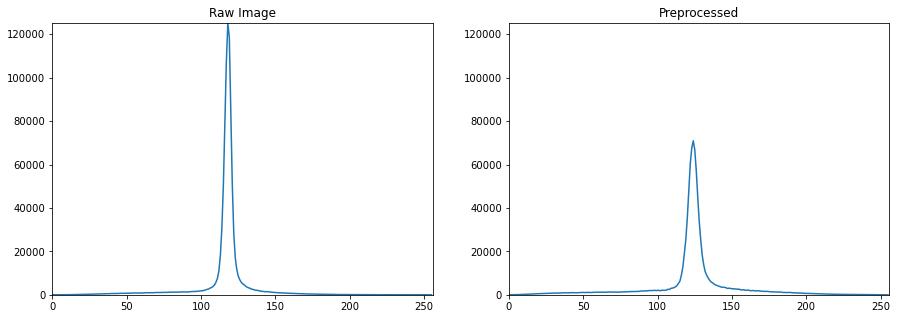

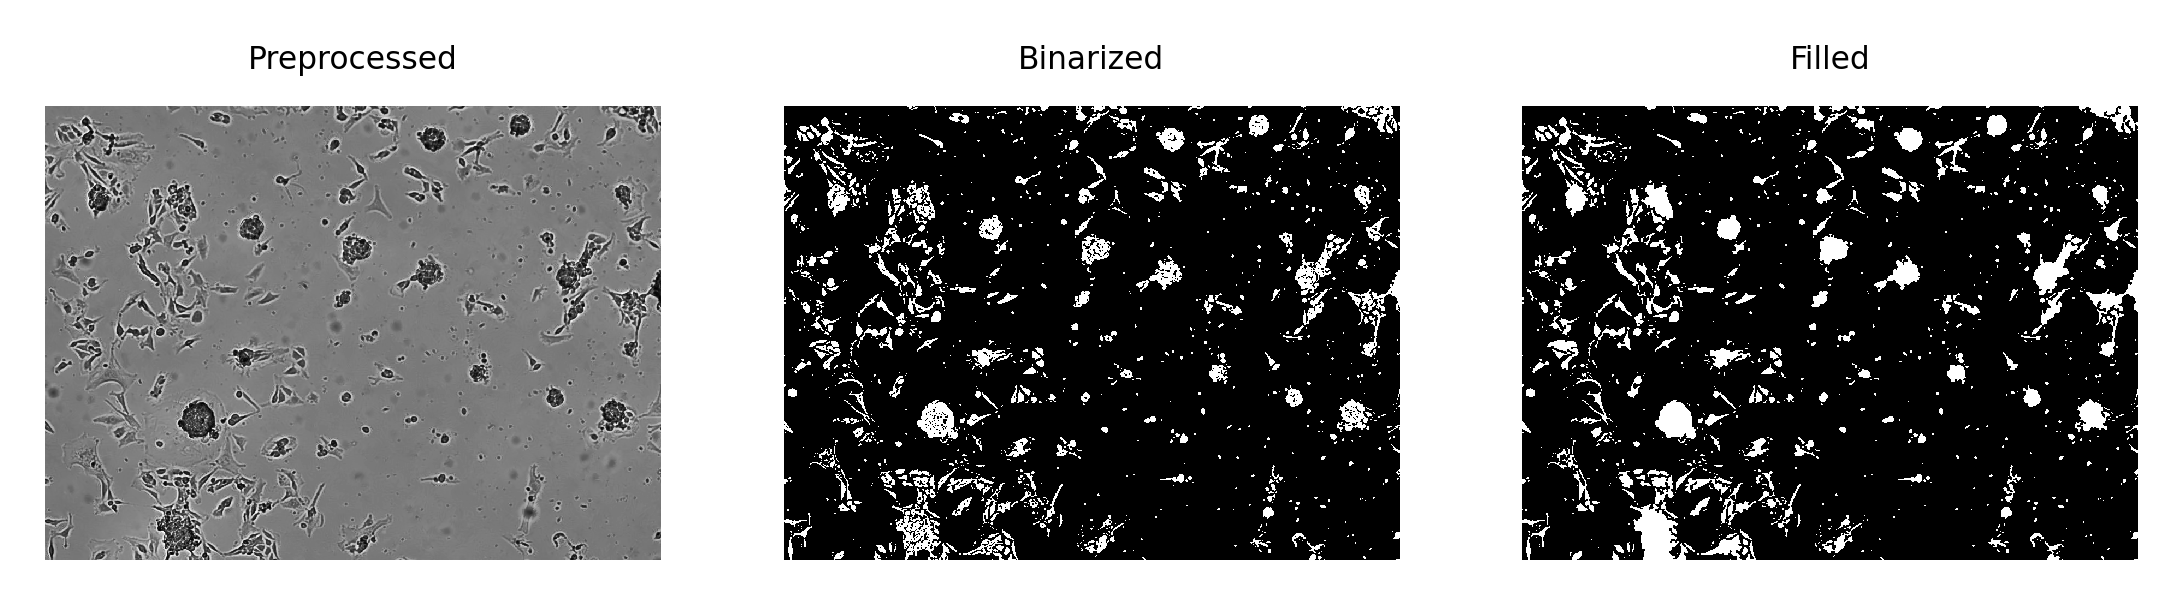

original_shape2D_Elongation  original_shape2D_MajorAxisLength  \
x   y                                                                    
235 2                       0.416260                         19.281618   
476 3                       0.619507                         15.783126   
541 14                      0.516784                         31.523831   
575 3                       0.404175                         24.980771   
621 7                       0.818371                         15.832663   
...                              ...                               ...   
972 816                     0.723547                         41.226964   
177 810                     0.479090                         20.794504   
407 815                     0.581474                         15.038612   
100 823                     0.487285                         22.564384   
169 825                     0.665801                         16.668267   

        original_shape2D_MaximumDiameter original_shape2D_MeshSurface  \
x   y                                                                   
235 2                 20.223748416156685                        107.5   
476 3                  17.08800749063506                        108.5   
541 14                 30.01666203960727                        334.5   
575 3                 25.317977802344327                        183.5   
621 7                  16.76305461424021                        153.5   
...                                  ...                          ...   
972 816                42.20189569201838                        419.5   
177 810                22.20360331117452                        157.5   
407 815               15.033296378372908                         99.5   
100 823               24.413111231467404                        191.5   
169 825               18.867962264113206                        130.5   

         original_shape2D_MinorAxisLength original_shape2D_Perimeter  \
x   y                                                                  
235 2                            8.026176          50.97056274847711   
476 3                            9.777763          45.79898987322329   
541 14                          16.290996           88.1837661840736   
575 3                           10.096594          66.62741699796948   
621 7                           12.956994         52.041630560342576   
...                                   ...                        ...   
972 816                         29.829646         190.61017305526673   
177 810                          9.962439          57.69848480983495   
407 815                          8.744561           41.2132034355964   
100 823                         10.995287         61.455844122715675   
169 825                         11.097745          50.14213562373094   

        original_shape2D_PerimeterSurfaceRatio  original_shape2D_PixelSurface  \
x   y                                                                           
235 2                       0.4741447697532754                          108.0   
476 3                      0.42211050574399345                          109.0   
541 14                     0.26362859845761916                          335.0   
575 3                       0.3630921907246293                          184.0   
621 7                         0.33903342384588                          154.0   
...                                        ...                            ...   
972 816                     0.4543746675930077                          420.0   
177 810                    0.36633958609419015                          158.0   
407 815                     0.4142030496039839                          100.0   
100 823                    0.32091824607162234                          192.0   
169 825                     0.3842309243197773                          131.0   

         original_shape2D_Sphericity original_firstorder_10Percentile  ...  \
x   y                      

In [4]:
raw_image = cv2.imreadmulti('source_images/Control.tif')[1][0]
mask_image = get_mask_image(raw_image, params, verbose=True)
df, masks = extract_features(raw_image, mask_image)
display(df)

## Scale features and reduce dimensions

In [5]:
scaler.fit(df.values)
pca.fit(df.values)

df = process_features(df)
display(df)

0             1            2           3          4   \
x   y                                                                     
235 2   -4.498994e+06 -12086.457871 -5021.476186  151.789096  93.995572   
476 3   -4.498994e+06 -12096.838993 -5023.484072  159.601120  89.720772   
541 14  -4.498993e+06 -12096.839447 -5023.344042  159.814500  89.791713   
575 3   -4.498994e+06 -12096.839567 -5023.506409  159.569917  89.563929   
621 7   -4.498994e+06 -12096.842583 -5023.645254  159.866960  89.967708   
...               ...           ...          ...         ...        ...   
972 816 -4.498993e+06 -12096.844491 -5023.721136  160.216810  90.451354   
177 810 -4.498994e+06 -12096.839097 -5023.452553  159.586662  89.606818   
407 815 -4.498994e+06 -12096.838019 -5023.471562  159.341177  89.266872   
100 823 -4.498994e+06 -12096.838694 -5023.334498  159.661247  89.649741   
169 825 -4.498994e+06 -12096.829110 -5023.054338  158.695134  88.791900   

                 5           6           7          8         9   ...  \
x   y                                                             ...   
235 2    472.559579  113.600151 -189.178336  80.985436  2.573308  ...   
476 3    470.519679  113.285998 -192.143709  78.364187  0.957309  ...   
541 14   469.467344  113.467777 -190.678946  77.387216  0.927623  ...   
575 3    470.756833  113.543524 -191.658147  78.073214  0.824816  ...   
621 7    469.729074  113.257015 -192.190696  78.306978  0.812047  ...   
...             ...         ...         ...        ...       ...  ...   
972 816  467.347550  113.290251 -191.266978  77.787157 -0.683582  ...   
177 810  470.883304  113.537884 -191.782880  78.111151  0.919067  ...   
407 815  471.730406  113.456383 -191.695441  78.176205  1.320361  ...   
100 823  470.117157  113.316324 -191.429371  77.883861  0.879706  ...   
169 825  471.439958  113.620153 -192.015091  78.493935  0.982870  ...   

               87        88        89        90        91        92        93  \
x   y                                                                           
235 2   -1.605089  0.645477 -1.220452  1.723495  0.177884 -0.245306  2.849427   
476 3   -0.188617  0.490248  0.737854 -0.121169 -0.941545  0.101655  0.567236   
541 14   0.017107  1.088624 -0.082548 -0.472828 -0.411375 -1.001288  0.064387   
575 3   -0.303927  0.570834  0.330702 -0.185902 -1.051085 -0.489818  0.655508   
621 7   -0.166886  0.715720  0.235684 -1.098918 -1.156319 -0.171312 -0.163934   
...           ...       ...       ...       ...       ...       ...       ...   
972 816  0.224393  0.325601  0.158980 -1.939677 -0.594478  0.276314 -0.484921   
177 810 -0.496801  0.259268  0.836235 -0.228309 -1.509956  0.361631  0.595097   
407 815 -0.781367 -0.106789  0.905192  0.388966 -1.330134 -0.000698  1.659198   
100 823 -0.193946  0.889542  0.319854 -0.511300 -0.682735 -0.305049  0.184655   
169 825 -1.058019 -0.229962  1.389501  0.267677 -2.042923  1.018590  1.400750   

               94        95        96  
x   y                                  
235 2   -1.071013  0.670494 -0.147093  
476 3   -0.281669 -1.037434  0.200250  
541 14   0.089237 -1.389868  0.261353  
575 3   -0.276047 -0.964004  0.186156  
621 7   -0.017333 -1.700730  0.319273  
...           ...       ...       ...  
972 816  0.338335 -2.108847  0.395513  
177 810 -0.136820 -1.124160  0.223051  
407 815 -0.727199 -0.399804  0.076450  
100 823  0.094206 -1.402624  0.265427  
169 825 -0.605713 -0.646145  0.132833  

[206 rows x 97 columns]

## Determine number of clusters

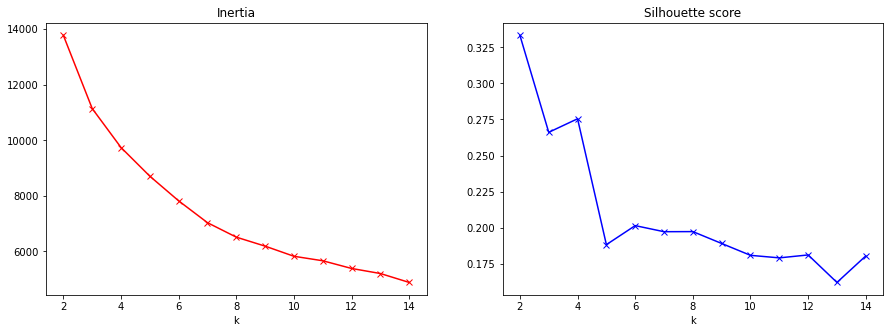

In [6]:
inertias = []
silhouette_scores = []
K = range(2, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(df)
    inertias += [kmeans.inertia_,]
    silhouette_scores += [silhouette_score(df, labels),]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(K, inertias, 'rx-')
ax1.set(xlabel='k', title="Inertia")
ax2.plot(K, silhouette_scores,'bx-')
ax2.set(xlabel='k', title="Silhouette score")
plt.show()

### User-defined values

In [7]:
# Manually select k based on visual inspection above
k = 4

# Classification colors (include k colors, or use colormap string)
colormap = matplotlib.colors.ListedColormap(['yellow', 'red', 'cyan', 'orange'])

## Fit and classify using silhouette score

Class 0: 55 (26.70%)
Class 1: 110 (53.40%)
Class 2: 39 (18.93%)
Class 3: 2 (0.97%)


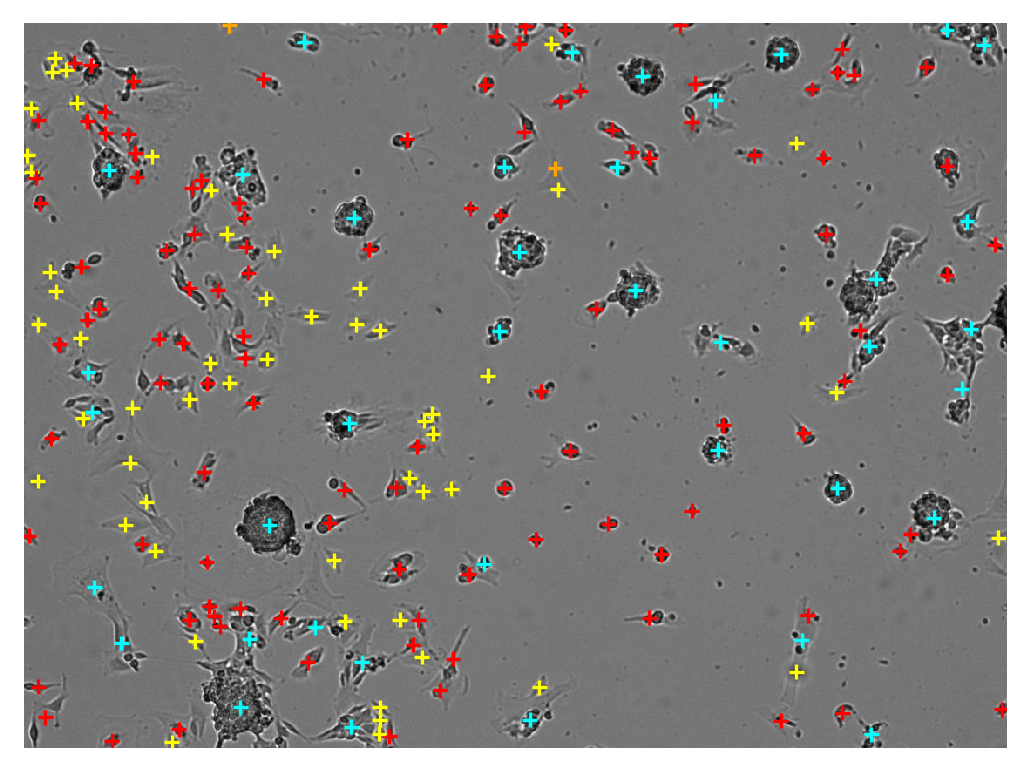

In [8]:
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(df)
labels = kmeans.predict(df)
display_classifications(raw_image, df.index, labels)

Class 0, with 55 ROIs:


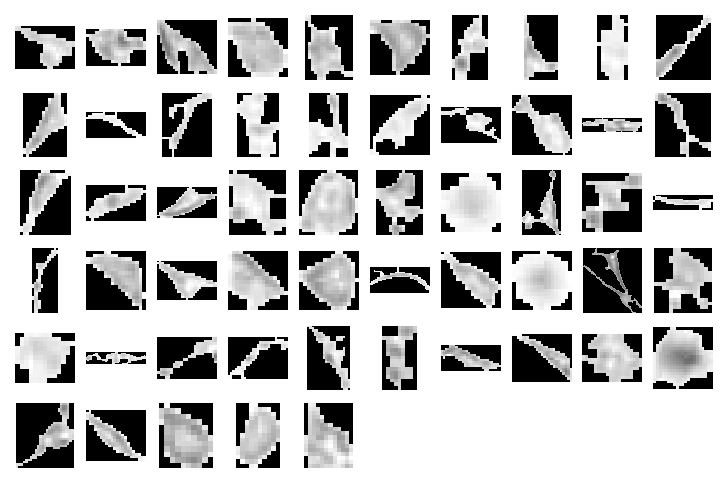

Class 1, with 110 ROIs:


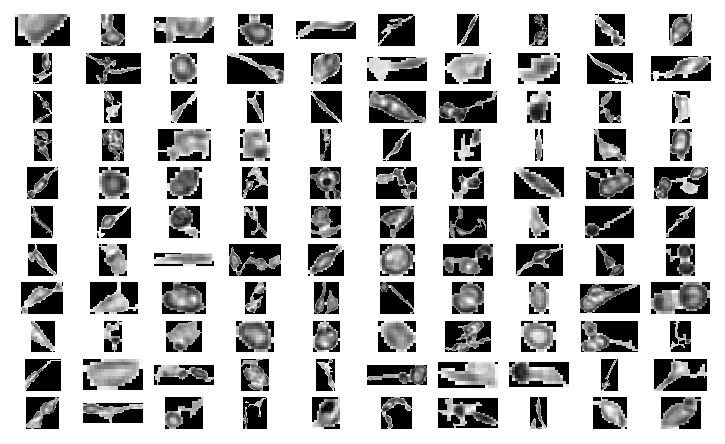

Class 2, with 39 ROIs:


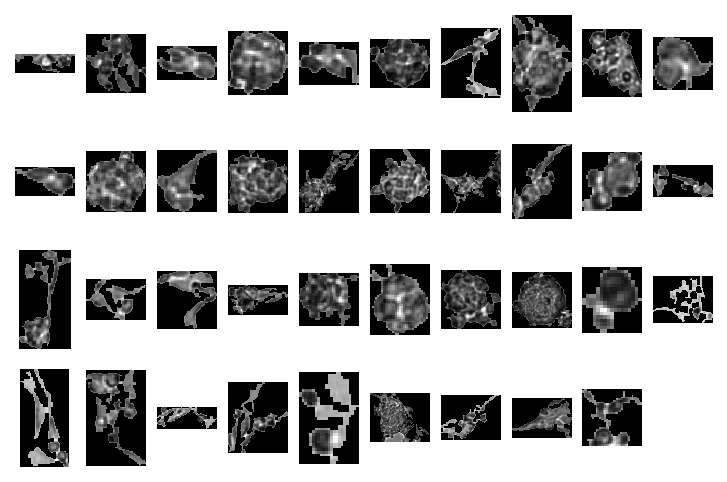

Class 3, with 2 ROIs:


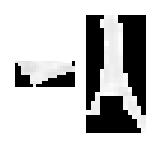

In [9]:
display_rois(raw_image, masks, labels)

## Cluster visualization

/Users/peteyeh/miniconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


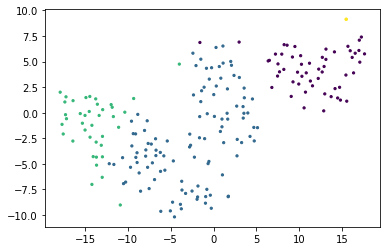

In [10]:
display_tsne(df)

# Experiment w/ multi-Otsu

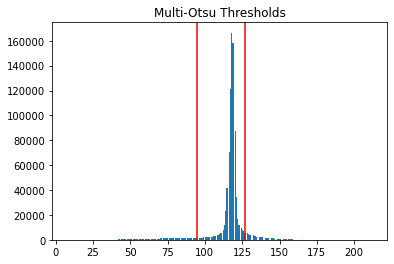

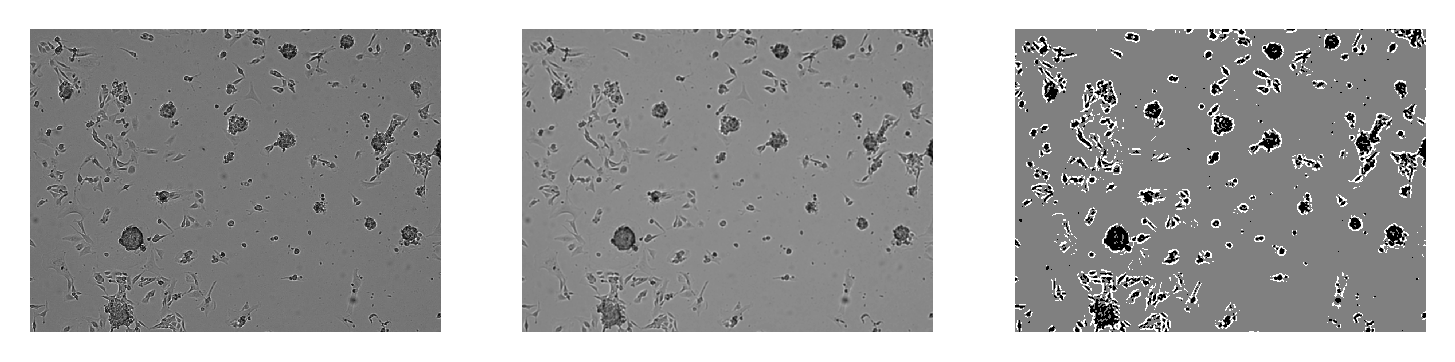

In [11]:
blurred = apply_blur(raw_image, 5)
thresholds = threshold_multiotsu(blurred)
multi_otsu_regions = np.digitize(blurred, bins=thresholds)

plt.hist(blurred.ravel(), bins=255)
plt.title('Multi-Otsu Thresholds')
for thresh in thresholds:
    plt.axvline(thresh, color='r')

display_image_array([raw_image, blurred, multi_otsu_regions],
                    columns=3, dpi=300)

# Classify cells on adherent image

Class 0: 61 (37.42%)
Class 1: 64 (39.26%)
Class 2: 37 (22.70%)
Class 3: 1 (0.61%)


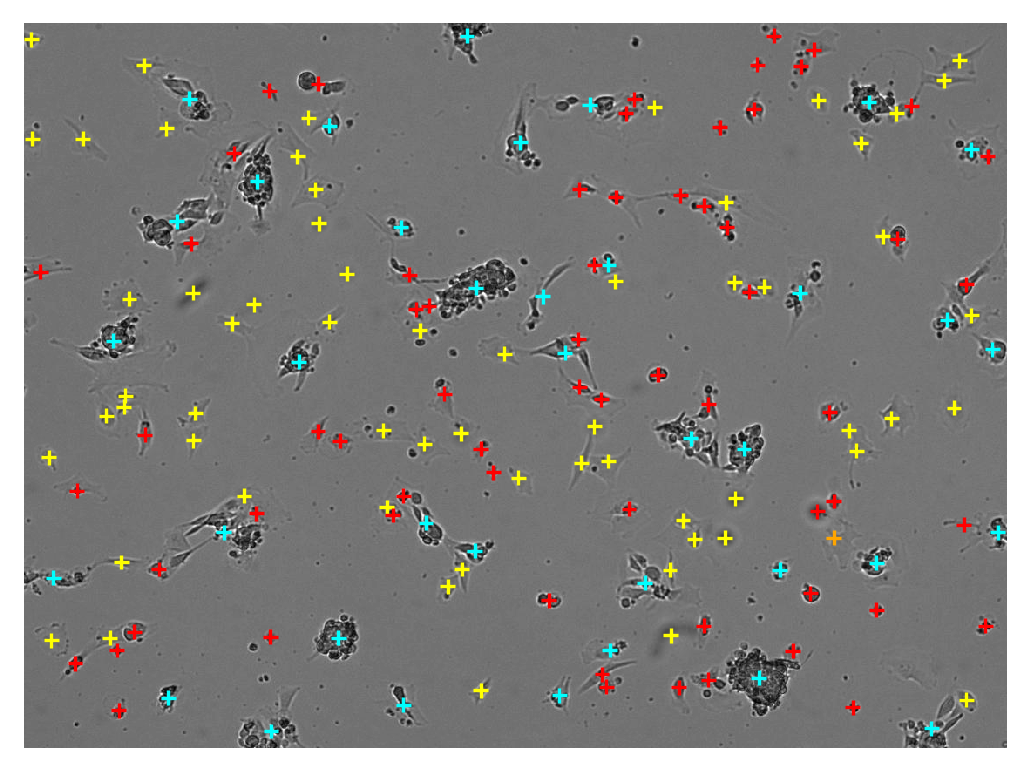

In [12]:
raw_image = cv2.imreadmulti('source_images/Adherent.tif')[1][0]
mask_image = get_mask_image(raw_image, params)
df, masks = extract_features(raw_image, mask_image)
df = process_features(df)
labels = kmeans.predict(df)
display_classifications(raw_image, df.index, labels)

Class 0, with 61 ROIs:


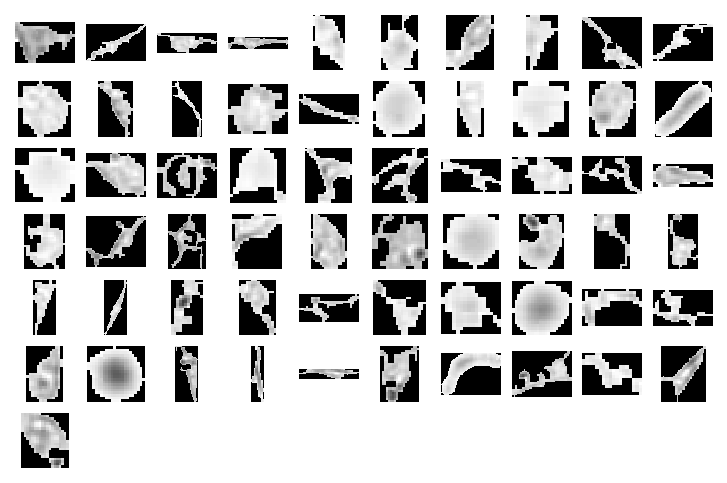

Class 1, with 64 ROIs:


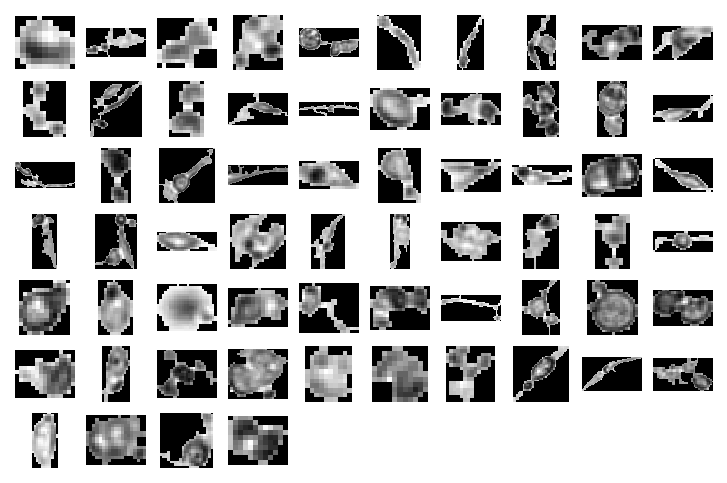

Class 2, with 37 ROIs:


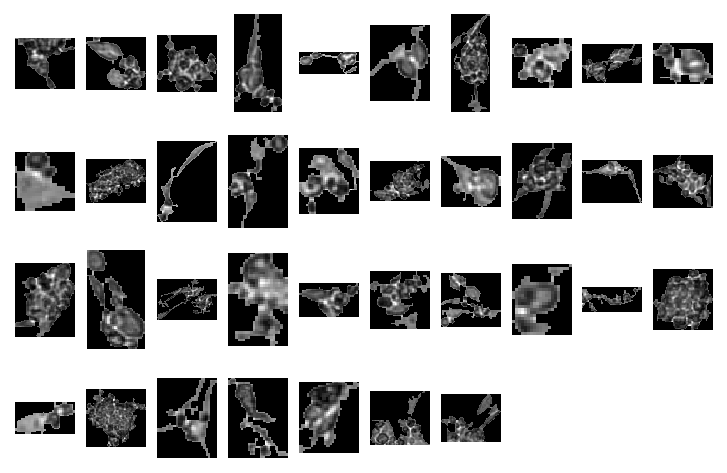

Class 3, with 1 ROIs:


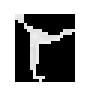

In [13]:
display_rois(raw_image, masks, labels)

/Users/peteyeh/miniconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


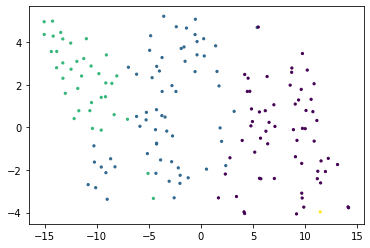

In [14]:
display_tsne(df)

# Classify cells on suspension image

Class 0: 61 (37.42%)
Class 1: 72 (44.17%)
Class 2: 22 (13.50%)
Class 3: 8 (4.91%)


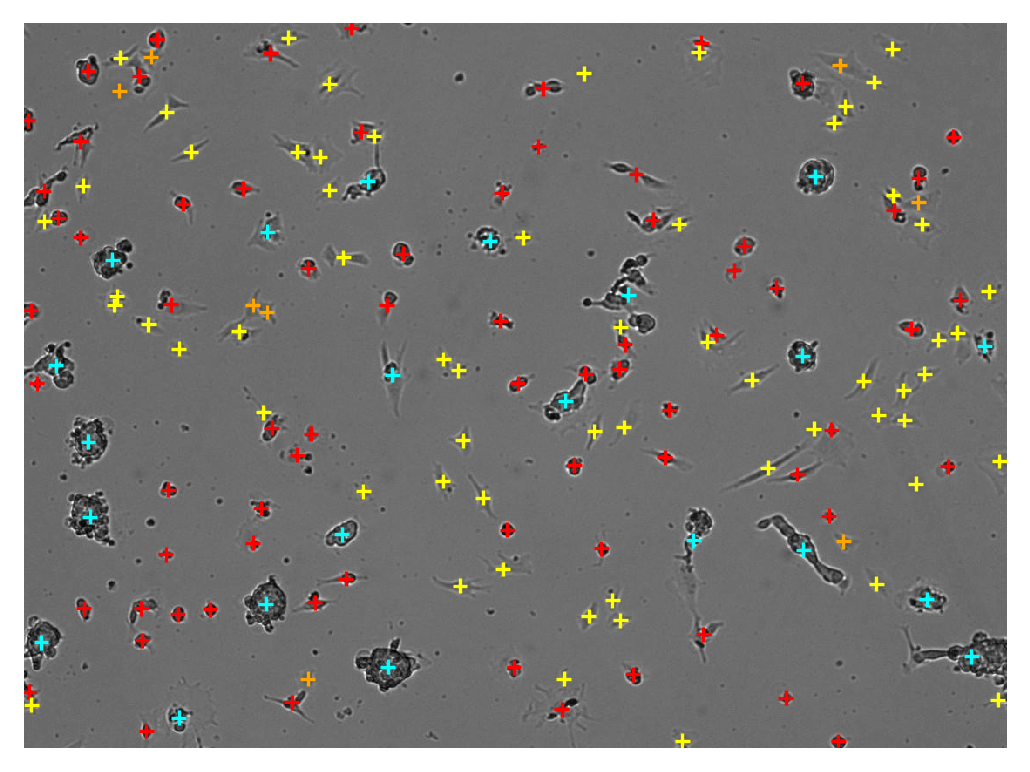

In [15]:
raw_image = cv2.imreadmulti('source_images/Suspension.tif')[1][0]
mask_image = get_mask_image(raw_image, params)
df, masks = extract_features(raw_image, mask_image)
df = process_features(df)
labels = kmeans.predict(df)
display_classifications(raw_image, df.index, labels)

Class 0, with 61 ROIs:


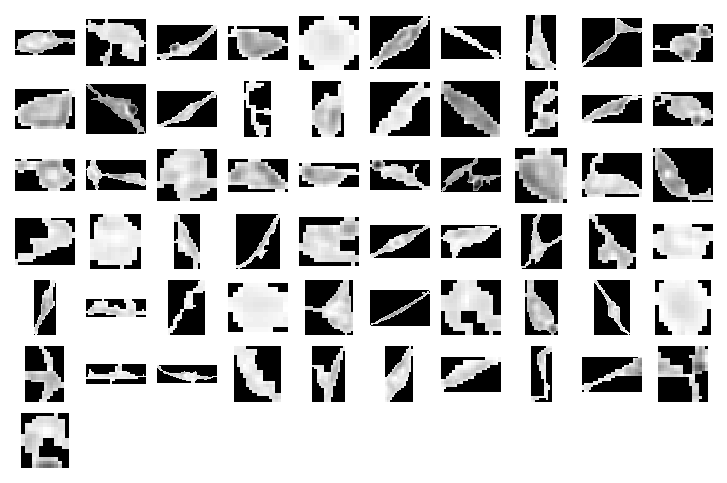

Class 1, with 72 ROIs:


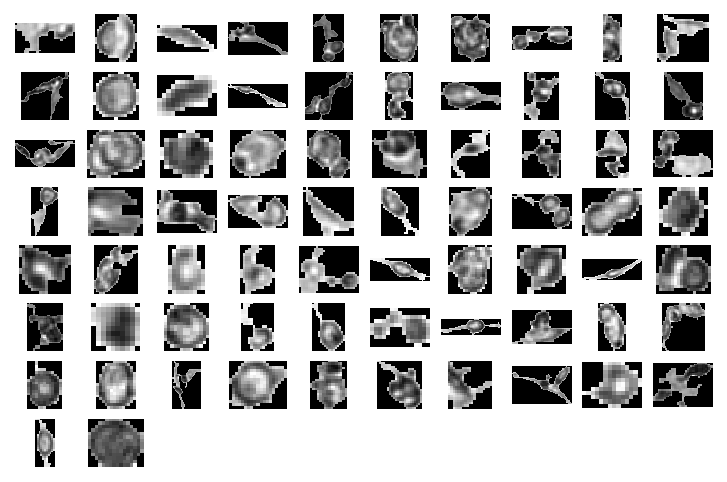

Class 2, with 22 ROIs:


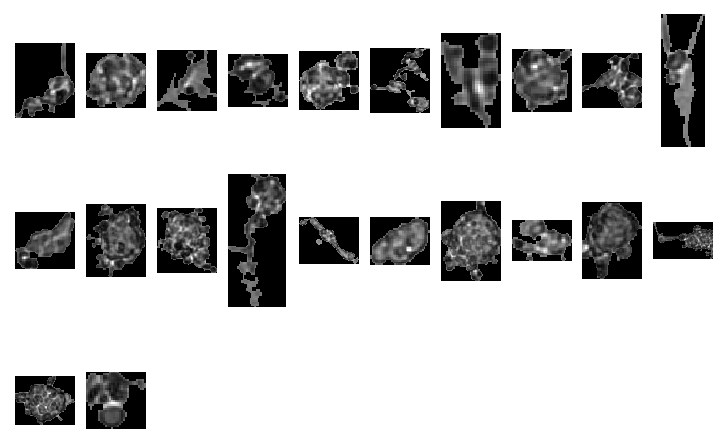

Class 3, with 8 ROIs:


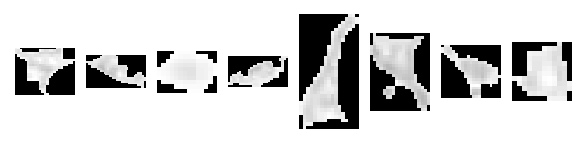

In [16]:
display_rois(raw_image, masks, labels)

/Users/peteyeh/miniconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


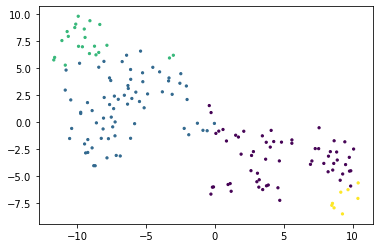

In [17]:
display_tsne(df)